# Imports

In [19]:
import pandas as pd
import os
import numpy as np
import time
import h5py
import librosa
import mido

# Progress bar

In [20]:
class ProgressBar:
    def __init__(self, total, length=40):
        self.total = total
        self.length = length
        self.current = 0
        self.start_time = time.time()

    def update(self, step=1):
        self.current += step
        progress = self.current / self.total
        filled_length = int(self.length * progress)
        bar = '=' * filled_length + '-' * (self.length - filled_length)
        if self.current == 1 or self.current == self.total or filled_length > int(self.length * ((self.current - step) / self.total)):
            print(f'\r|{bar}| {self.current}/{self.total} ({progress:.2%})  {time.time() - self.start_time:.1f}s', end='')

# Dataset generator

In [21]:
class DatasetGenerator():
    def __init__(
        self,
        wav_mid_df: pd.DataFrame,
        output_path: str,
        chunk_size: int = 128,
        step_size: int = 64,
        sample_rate: int = 12_800,
        n_fft: int = 2048,
        hop_length: int = 256,
        n_mels: int = 512,
        override: bool = False,
    ):
        self.wav_mid_df = wav_mid_df
        self.output_path = output_path
        self.chunk_size = chunk_size
        self.step_size = step_size
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.time_per_frame = hop_length / sample_rate

        if override and os.path.exists(self.output_path):
            os.remove(self.output_path)

    def _get_spectogram(self, wave_path: str) -> np.ndarray:
        samples, sr = librosa.load(wave_path, sr=self.sample_rate)

        mel_spectrogram = librosa.feature.melspectrogram(
            y=samples, sr=sr, n_fft=self.n_fft, hop_length=self.hop_length, n_mels=self.n_mels)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

        return mel_spectrogram_db

    def _get_message_df(self, midi_path) -> pd.DataFrame:
        mid = mido.MidiFile(midi_path)
        ticks_per_beat = mid.ticks_per_beat
        tempo = 500_000
        for msg in mid:
            if msg.type == 'set_tempo':
                tempo = msg.tempo
                break
        note_msg = map(lambda x: (x, x.time), mid.tracks[-1])
        note_df = pd.DataFrame(note_msg, columns=['other', 'time'])
        note_df['time'] *= tempo / 1000 / ticks_per_beat
        note_df['time'] = note_df['time'].cumsum()
        note_df['time'] = note_df['time'].astype(np.int32)

        note_df = note_df[note_df['other'].apply(
            lambda x: x.type == 'note_on')]
        note_df['note'] = note_df['other'].apply(lambda x: x.note)
        note_df['velocity'] = note_df['other'].apply(lambda x: x.velocity)
        note_df = note_df.drop(columns=['other']).reset_index(drop=True)
        return note_df
    
    def _get_spec_chunk(self, spec: np.ndarray, i: int) -> np.ndarray:
        spec_chunk = spec[:, i * self.step_size : i * self.step_size + self.chunk_size].copy()
        spec_chunk = (spec_chunk - spec_chunk.min()) / (spec_chunk.max() - spec_chunk.min()) * 255
        spec_chunk = spec_chunk.astype(np.uint8)
        return spec_chunk

    def _get_midi_chunk(self, midi: pd.DataFrame, i: int) -> np.ndarray:
        start_time = i * self.step_size * self.time_per_frame * 1000
        end_time = (i * self.step_size + self.chunk_size) * self.time_per_frame * 1000

        midi_chunk = midi[(midi['time'] >= start_time) & (midi['time'] < end_time)].copy()
        midi_chunk['time'] = midi_chunk['time'] - int(start_time)
        return midi_chunk.to_numpy()
    
    def _get_chunk_meta(self, midi_chunk: np.ndarray):
        if midi_chunk.shape[0] == 0:
            return np.array([0, 0, 0])
        meta = [midi_chunk[:, 1].min(), midi_chunk[:, 1].max(), len(midi_chunk)]
        return meta
    
    def _get_chunks(self, wave_path: str, midi_path: str) -> pd.DataFrame:
        spec = self._get_spectogram(wave_path)
        midi = self._get_message_df(midi_path)

        length = int((spec.shape[1] - self.chunk_size) / self.step_size)
        chunks = []
        for i in range(length):
            spec_chunk = self._get_spec_chunk(spec, i)
            midi_chunk = self._get_midi_chunk(midi, i)
            
            chunks.append((spec_chunk, midi_chunk))
        return pd.DataFrame(chunks, columns=['spec', 'midi'])

    def _save_chunk(self, spec_chunk: np.ndarray, midi_chunk: np.ndarray, piece_name: str):
        with h5py.File(self.output_path, 'a') as h5:
            if piece_name not in h5:
                piece_group = h5.create_group(piece_name)
            else:
                piece_group = h5[piece_name]

            chunk_idx = len(piece_group)
            chunk_group = piece_group.create_group(f'chunk_{chunk_idx}')

            chunk_group.create_dataset('image', data=spec_chunk, compression='gzip')
            chunk_group.create_dataset('midi', data=midi_chunk, compression='gzip')
            chunk_group.create_dataset('meta', data=self._get_chunk_meta(midi_chunk), compression='gzip')

    def generate(self):
        output_dir = os.path.dirname(self.output_path)
        if output_dir and not os.path.exists(output_dir):
            os.makedirs(output_dir)

        progress_bar = ProgressBar(len(self.wav_mid_df))
        for i, (idx, row) in enumerate(self.wav_mid_df.iterrows()):
            wave_path = row['wav']
            midi_path = row['midi']
            piece_name = os.path.basename(wave_path).split('.')[0]

            if os.path.exists(wave_path) and os.path.exists(midi_path):
                chunks = self._get_chunks(wave_path, midi_path)
                for _, (spec_chunk, midi_chunk) in chunks.iterrows():
                    self._save_chunk(spec_chunk, midi_chunk, piece_name)
            else:
                print(f"File not found: {wave_path} or {midi_path}")

            progress_bar.update()


    # def _getSimpleSpectogram(self, wave_file: str, notes: list[int]):
    #     spec = self.getSpectogram(wave_file)
    #     mel_frequencies = librosa.mel_frequencies(n_mels=spec.shape[0], fmin=0, fmax=self.sample_rate / 2)

    #     note_freqs = pd.read_csv('note_freqs.csv').values
    #     indexes = np.array([mel_frequencies[np.abs(mel_frequencies - val).argmin()] for val in note_freqs])
    #     indexes = np.array([np.where(mel_frequencies == val)[0][0] for val in indexes])
    #     indexes = indexes[notes]

    #     spec = spec[indexes]
    #     return spec, mel_frequencies[indexes]

# Generate

In [22]:
csv_path = 'wav_midi.csv'
h5_path = f'dataset.h5'
folder_path = 'waves'

df = pd.read_csv(csv_path)
df['wav'] = df['wav'].apply(lambda x: os.path.join(folder_path, x))
df['midi'] = df['midi'].apply(lambda x: os.path.join(folder_path, x))
# df = df.sample(2)

dataset_gen = DatasetGenerator(df, h5_path, override=True)

In [23]:
# dataset_gen.generate()

|========================================| 300/300 (100.00%)  279.6s

In [ ]:
# with h5py.File(h5_path, 'r') as h5:
#     paths = []
#     for piece_name in h5.keys():
#         piece_group = h5[piece_name]
#         for chunk_name in piece_group.keys():
#             paths.append((piece_name, chunk_name))

[[ 102   62   52]
 [ 109   53   46]
 [ 213   62    0]
 [ 467   53    0]
 [ 481   79    0]
 [ 490   65   49]
 [ 493   77   70]
 [ 513   58   46]
 [ 555   65    0]
 [ 608   58    0]
 [ 694   77    0]
 [ 902   77   75]
 [ 906   45   47]
 [1049   45    0]
 [1302   60   56]
 [1319   53   47]
 [1451   60    0]
 [1683   53    0]
 [1691   65   55]
 [1700   60   53]
 [1751   65    0]
 [1792   60    0]
 [2095   45   50]
 [2110   72   67]
 [2148   77    0]
 [2247   45    0]
 [2522   60   52]
 [2539   53   43]]


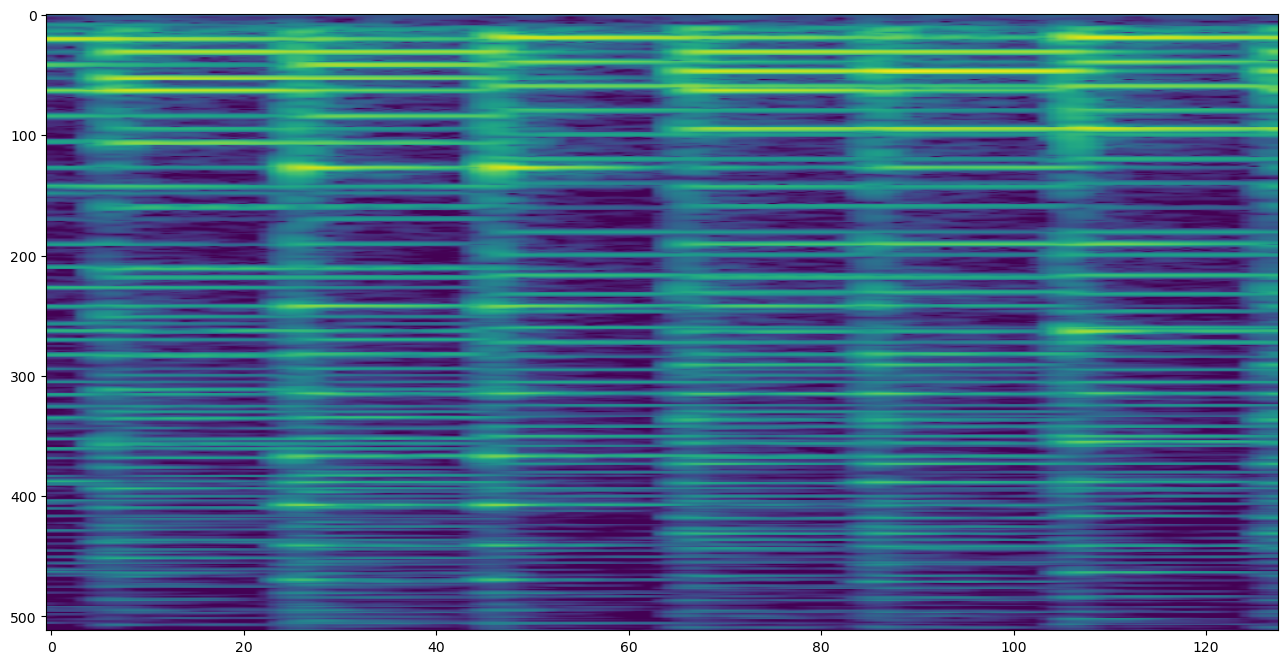

[[   8   51   70]
 [  78   51    0]
 [  83   48   59]
 [ 174   48    0]
 [ 181   49   60]
 [ 207   73    0]
 [ 221   72   82]
 [ 253   51   71]
 [ 268   66    0]
 [ 269   49    0]
 [ 272   69    0]
 [ 297   51    0]
 [ 338   52   74]
 [ 392   52    0]
 [ 431   49   49]
 [ 489   51   67]
 [ 490   49    0]
 [ 523   51    0]
 [ 575   52   60]
 [ 576   73   84]
 [ 583   72    0]
 [ 588   68   49]
 [ 598   64   57]
 [ 630   52    0]
 [ 667   54   66]
 [ 690   64    0]
 [ 726   54    0]
 [ 751   51   60]
 [ 805   51    0]
 [ 819   52   60]
 [ 889   52    0]
 [ 901   54   69]
 [ 924   68    0]
 [ 932   69   86]
 [ 956   54    0]
 [ 962   63   54]
 [ 989   56   64]
 [1035   56    0]
 [1076   52   67]
 [1173   52    0]
 [1200   54   53]
 [1260   54    0]
 [1260   56   72]
 [1294   72   86]
 [1299   68   58]
 [1303   56    0]
 [1308   73    0]
 [1352   68    0]
 [1355   57   70]
 [1360   69    0]
 [1399   57    0]
 [1455   56   75]
 [1521   63    0]
 [1542   54   67]
 [1549   56    0]
 [1578   5

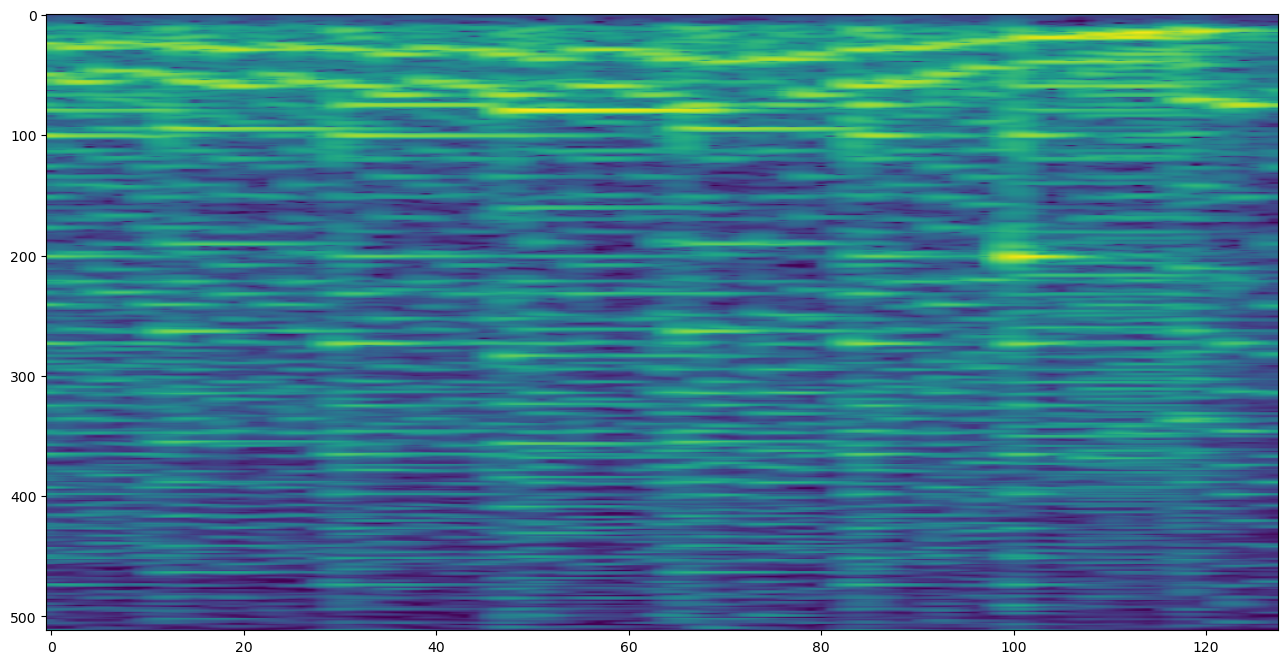

[[ 117   76   70]
 [ 119   61   60]
 [ 170   61    0]
 [ 171   76    0]
 [ 337   66   66]
 [ 337   81   74]
 [ 372   81    0]
 [ 374   66    0]
 [ 533   62   67]
 [ 540   78   79]
 [ 573   62    0]
 [ 587   78    0]
 [ 753   67   67]
 [ 756   83   74]
 [ 795   67    0]
 [ 837   83    0]
 [ 840   79   73]
 [ 930   79    0]
 [ 934   76   72]
 [ 993   76    0]
 [1024   74   68]
 [1080   74    0]
 [1098   67   71]
 [1196   67    0]
 [1201   69   73]
 [1238   69    0]
 [1262   73   73]
 [1297   73    0]
 [1322   76   67]
 [1386   76    0]
 [1389   81   67]
 [1430   81    0]
 [1457   85   72]
 [1495   85    0]
 [1709   86   68]
 [1726   66   34]
 [1772   86    0]
 [1807   66    0]]


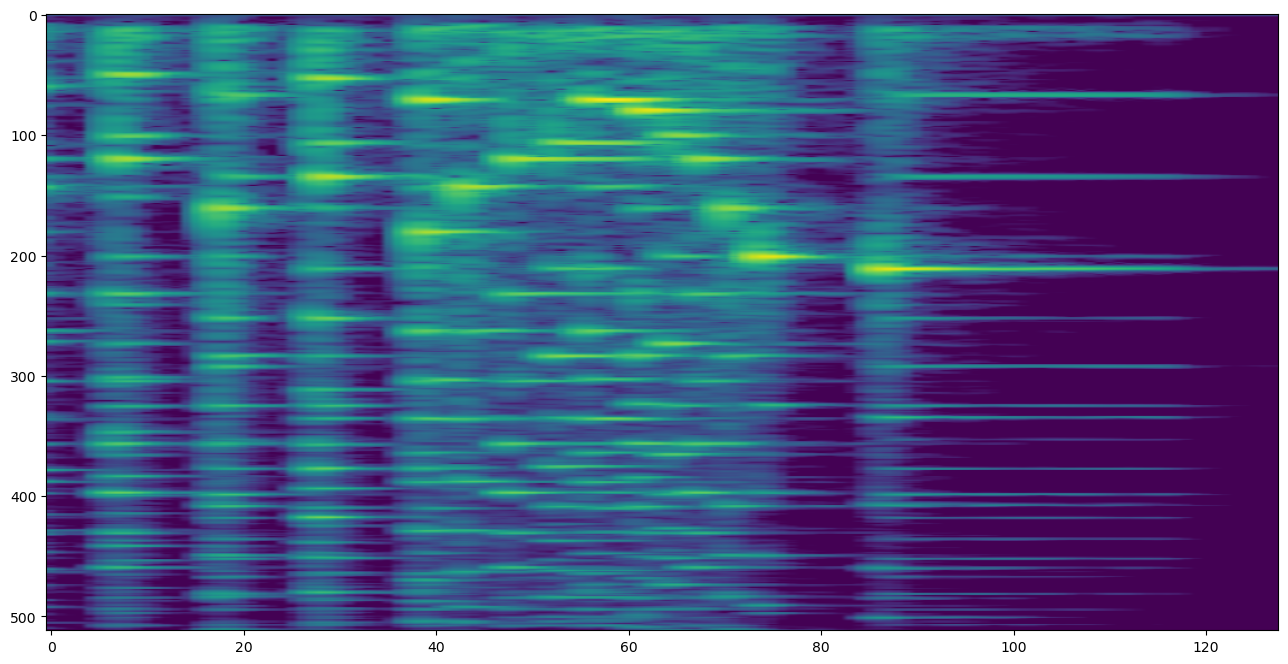

[[   6   49   79]
 [  14   37   70]
 [  50   49    0]
 [  61   37    0]
 [ 271   47   74]
 [ 279   35   71]
 [ 279   83   93]
 [ 439   83    0]
 [ 458   81   70]
 [ 520   79   68]
 [ 545   81    0]
 [ 548   78   70]
 [ 566   79    0]
 [ 587   78    0]
 [ 632   76   65]
 [ 676   76    0]
 [ 682   74   71]
 [ 721   35    0]
 [ 730   73   82]
 [ 749   74    0]
 [ 760   47    0]
 [ 804   71   85]
 [ 821   73    0]
 [ 860   71    0]
 [1031   37   74]
 [1031   49   72]
 [1070   49    0]
 [1072   37    0]
 [1265   50   77]
 [1270   38   76]
 [1307   50    0]
 [1311   38    0]
 [1512   52   79]
 [1518   40   76]
 [1562   40    0]
 [1564   52    0]
 [1771   42   81]
 [1781   73   81]
 [1788   70   77]
 [1857   42    0]
 [1868   70    0]
 [1877   73    0]
 [1902   54   70]
 [1908   66   74]
 [2033   54    0]
 [2037   74   75]
 [2041   66    0]
 [2045   47   64]
 [2046   71   72]
 [2128   71    0]
 [2139   47    0]
 [2148   74    0]
 [2158   66   77]
 [2170   54   70]
 [2275   54    0]
 [2282   6

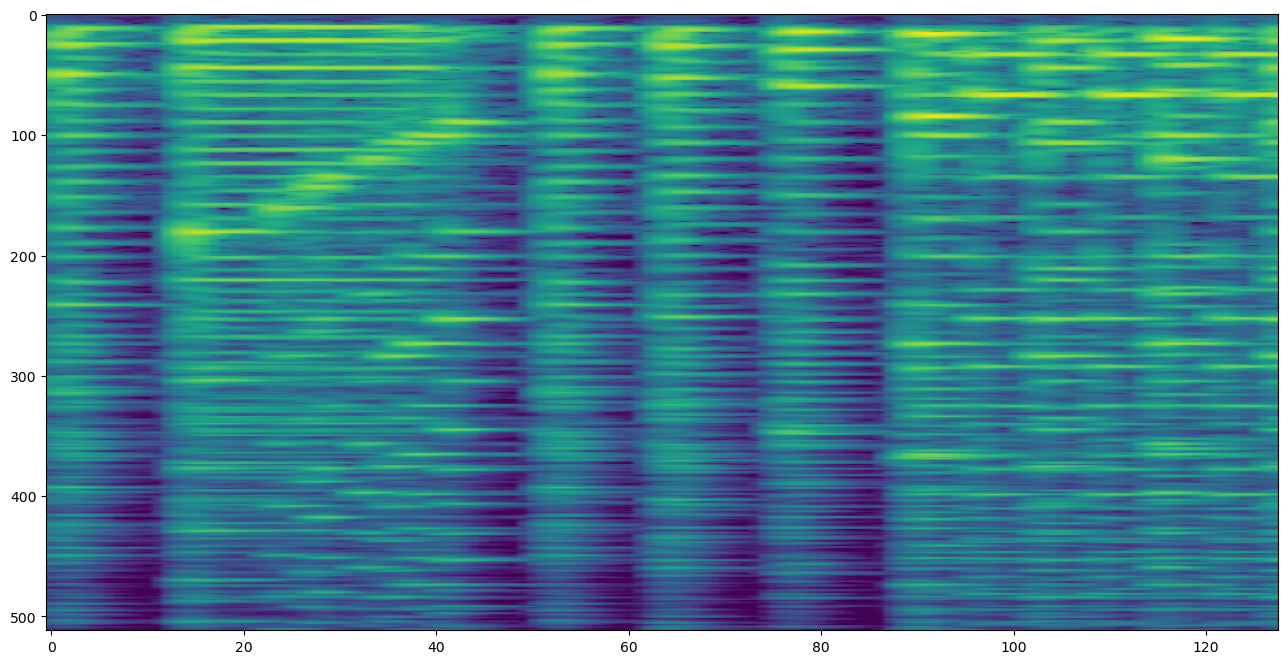

[[  65   46   65]
 [ 147   46    0]
 [ 186   67   94]
 [ 190   61   84]
 [ 190   64   89]
 [ 225   64    0]
 [ 245   61    0]
 [ 260   67    0]
 [ 581   85   94]
 [ 582   91   94]
 [ 604   82   75]
 [ 638   85    0]
 [ 665   88   84]
 [ 676   82    0]
 [ 702   91    0]
 [ 745   84   88]
 [ 746   75   78]
 [ 749   78   73]
 [ 780   88    0]
 [ 819   84    0]
 [ 824   81   86]
 [ 835   78    0]
 [ 858   75    0]
 [ 885   76   78]
 [ 895   79   81]
 [ 904   81    0]
 [ 909   85   87]
 [ 926   79    0]
 [ 956   76    0]
 [ 990   82   95]
 [1018   85    0]
 [1046   82    0]
 [1242   46   72]
 [1301   54   81]
 [1366   46    0]
 [1383   69   97]
 [1389   63   90]
 [1395   60   87]
 [1466   63    0]
 [1530   60    0]
 [1552   54    0]
 [1552   69    0]
 [1960   87   94]
 [1970   93   85]
 [2000   84   60]
 [2030   87    0]
 [2065   84    0]
 [2069   90   82]
 [2109   93    0]
 [2152   77   73]
 [2152   86   82]
 [2163   80   68]
 [2182   90    0]
 [2221   77    0]
 [2224   86    0]
 [2229   8

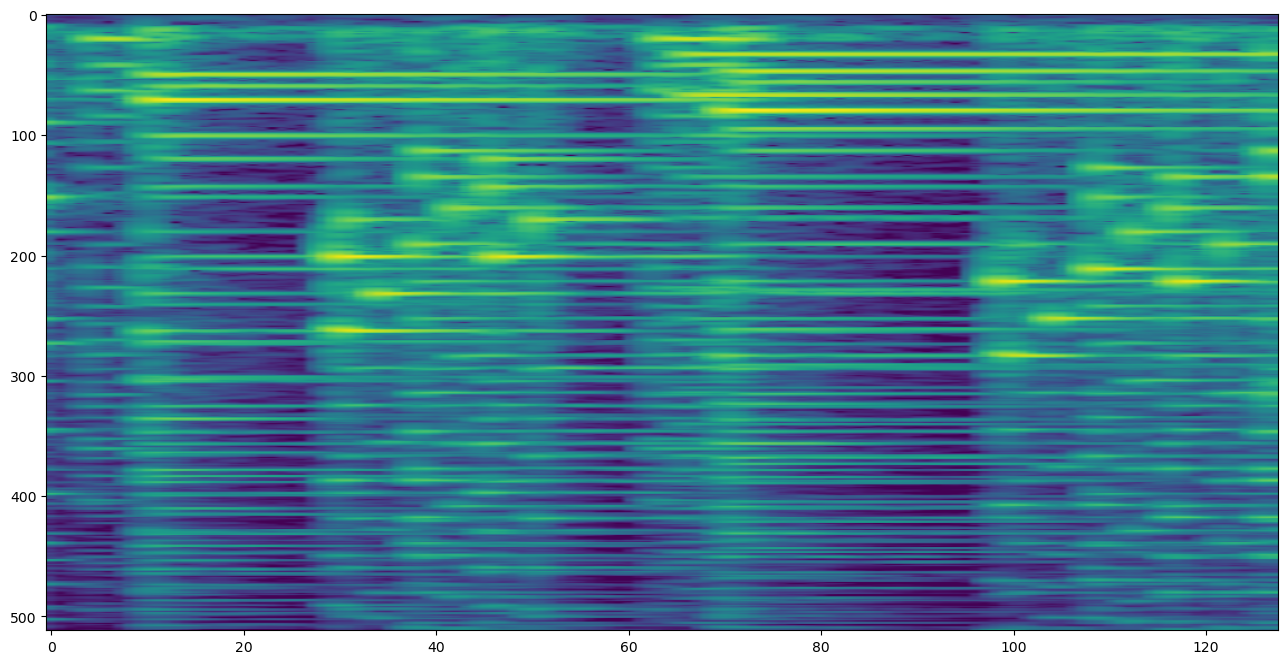

In [ ]:
# import random
# import matplotlib.pyplot as plt

# with h5py.File(h5_path, 'r') as h5:
#     mypaths = random.sample(paths, 5)
#     for p in mypaths:
#         chunk_group = h5[p[0]][p[1]]
#         spec = chunk_group['image'][()]
#         midi = chunk_group['midi'][()]
#         meta = chunk_group['meta'][()]
#         print(midi)
#         plt.figure(figsize=(20, 8))
#         plt.imshow(spec, aspect=1/8)
#         plt.show()